## Setup and Imports

Importing required libraries and dependencies.

In [1]:
# ensures that matplotlib plots are disdplayed inside the notebook 
%matplotlib inline

# provides access to system-specific parameters and functions
import sys
# helps with file and directory operations, enviornment variables, and process control
import os
# for image loading, processing, and manipulation
import cv2
import shutil

import matplotlib # for plotting and visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.mplot3d import axes3d # for creating 3D plots
from tqdm import tqdm # library used for displaying progress bars for loops
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
)

import pathlib
import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random 
print("Version information")

print("python: {}".format(sys.version))
print("matplotlib: {}".format(matplotlib.__version__))
print("numpy: {}".format(np.__version__))
print("tensorflow: {}".format(tf.__version__))
print("current working directory:", os.getcwd()) # prints curr working directory
print("list of files:", os.listdir())  # Lists the files in the current directory
print("cv2 version:", cv2.__version__)
print("tensorflow: {}".format(tf.__version__))

# Load image
import imageio

# automatically reloads modules before executing code
%load_ext autoreload
%autoreload 2

Version information
python: 3.12.1 (v3.12.1:2305ca5144, Dec  7 2023, 17:23:38) [Clang 13.0.0 (clang-1300.0.29.30)]
matplotlib: 3.9.2
numpy: 1.26.4
tensorflow: 2.17.0
current working directory: /Users/erin/Library/Mobile Documents/com~apple~CloudDocs/1_gt/2_gatechJunior/Fall24/CS4641/Alzheimer-Detection/notebooks
list of files: ['2_Model_2.ipynb', '1_CNN.ipynb', 'cnn.keras', '3_SVM.ipynb', 'data_split', '__pycache__', 'preprocessing.py', 'preprocessing_svm.py']
cv2 version: 4.10.0
tensorflow: 2.17.0


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17094853665383607019
xla_global_id: -1
]


## Dataset Parameters and Classes

In [3]:
DATASET_PATH = "../data/"
BATCH_SIZE = 32
IMAGE_SIZE = (128, 128)
data_dir = pathlib.Path(DATASET_PATH)
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

# Corrupt Image Detection

In [4]:
from PIL import Image
import os

for root, _, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith(('jpg', 'jpeg', 'png')):
            try:
                img = Image.open(os.path.join(root, file))
                img.load()  # Load image to detect issues
            except Exception as e:
                print(f"Corrupted image detected: {os.path.join(root, file)} - {e}")

## Dataset Directory Setup and Splitting

In [5]:
# print dataset directory path to confirm it's correct / exist
print(f"Dataset Directory: {data_dir}")
print(f"Directory Exists: {data_dir.exists()}")

# since using preprocessing_svm.py, load data using script

# import the preprocessing_svm module
import sys
sys.path.append('.')
import preprocessing_svm

print("Starting preprocessing for SVM: ...")
X_train, X_val, X_test, y_train, y_val, y_test = preprocessing_svm.preprocess_svm(DATASET_PATH)
print("Preprocessing completed")

# print data split
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# check if splits are independent and correctly distributed
for split_name, y_split in zip(['Train', 'Validation', 'Test'], [y_train, y_val, y_test]):
    unique, counts = np.unique(y_split, return_counts=True)
    print(f"{split_name} class distribution: {dict(zip(unique, counts))}")

# check for overlap between sets
train_set = set(map(tuple, X_train))
val_set = set(map(tuple, X_val))
test_set = set(map(tuple, X_test))

print("Overlap between train and validation:", len(train_set & val_set))
print("Overlap between train and test:", len(train_set & test_set))
print("Overlap between validation and test:", len(val_set & test_set))



Dataset Directory: ../data
Directory Exists: True
Starting preprocessing for SVM: ...
Loaded 5002 images for class 'Mild Dementia'
Loaded 488 images for class 'Moderate Dementia'
Loaded 67222 images for class 'Non Demented'
Loaded 13725 images for class 'Very mild Dementia'
Total images loaded: 86437
Preprocessing completed
Training samples: 60505
Validation samples: 8644
Testing samples: 17288
Train class distribution: {0: 3502, 1: 341, 2: 47055, 3: 9607}
Validation class distribution: {0: 500, 1: 49, 2: 6722, 3: 1373}
Test class distribution: {0: 1000, 1: 98, 2: 13445, 3: 2745}
Overlap between train and validation: 0
Overlap between train and test: 0
Overlap between validation and test: 0


## Sample Dataset Image Visualization

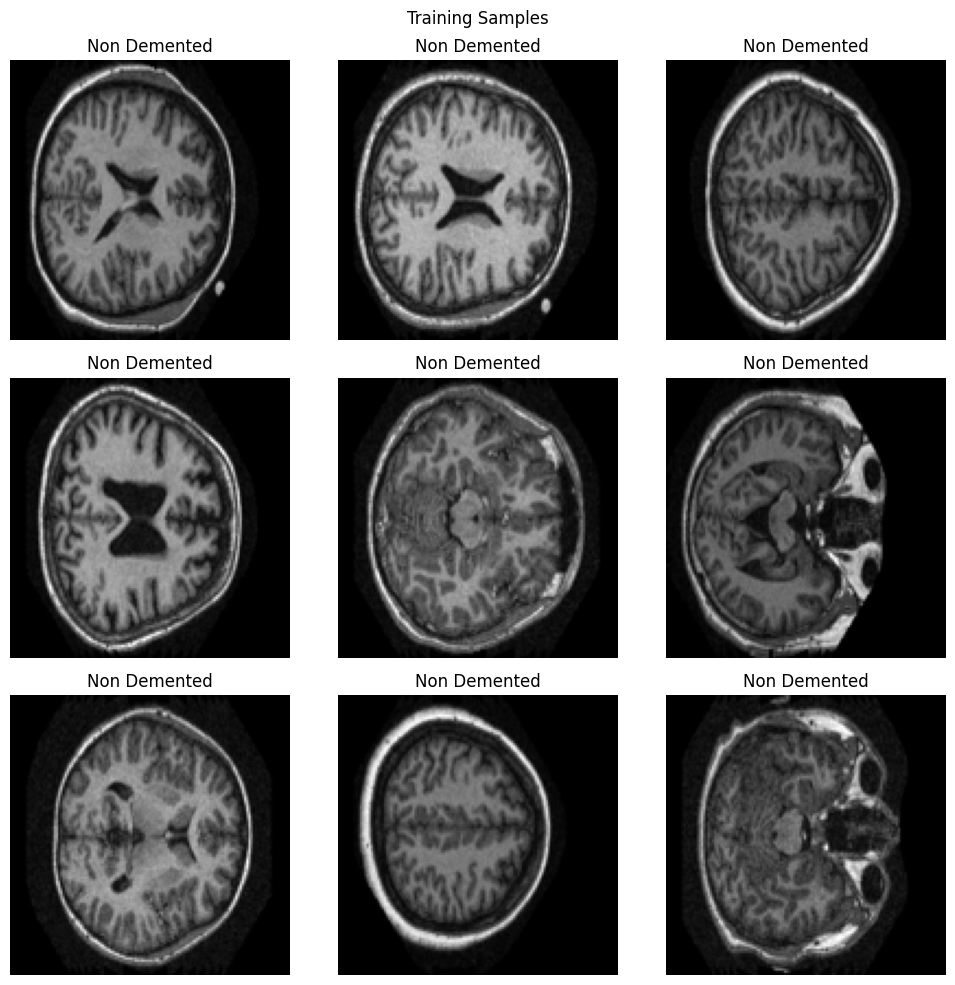

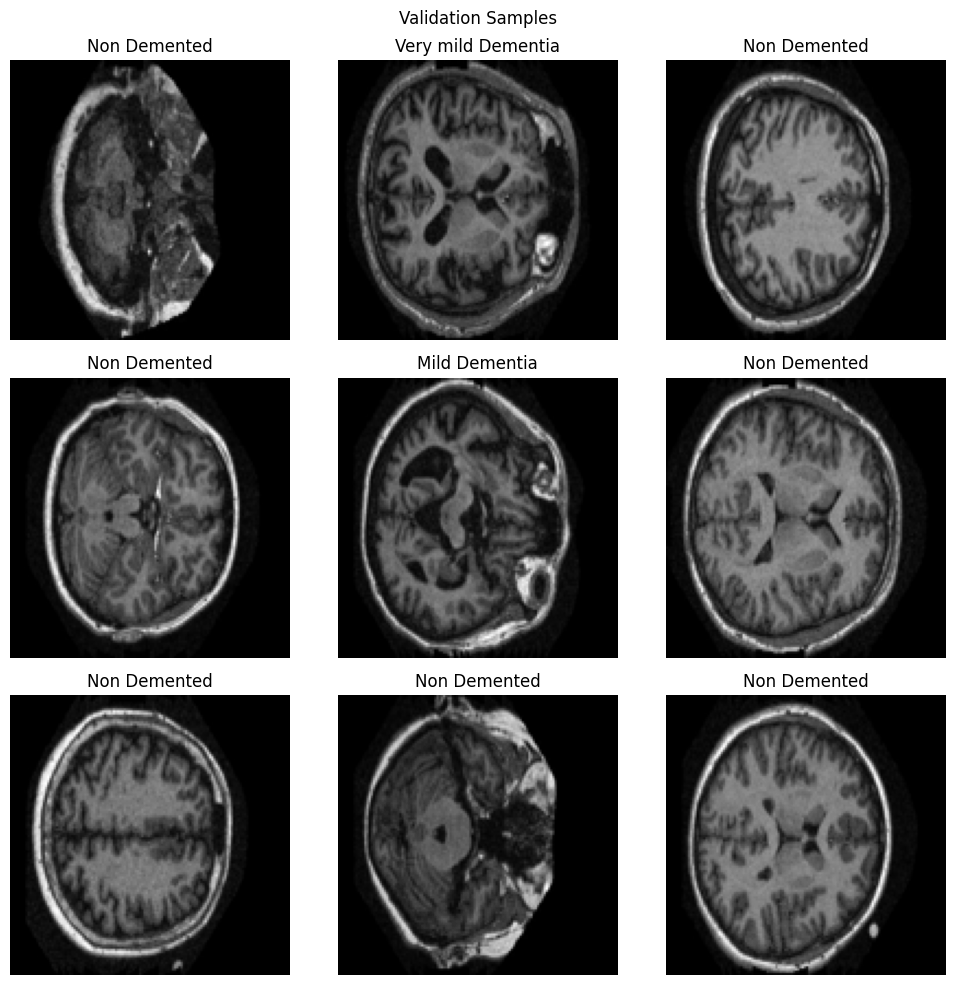

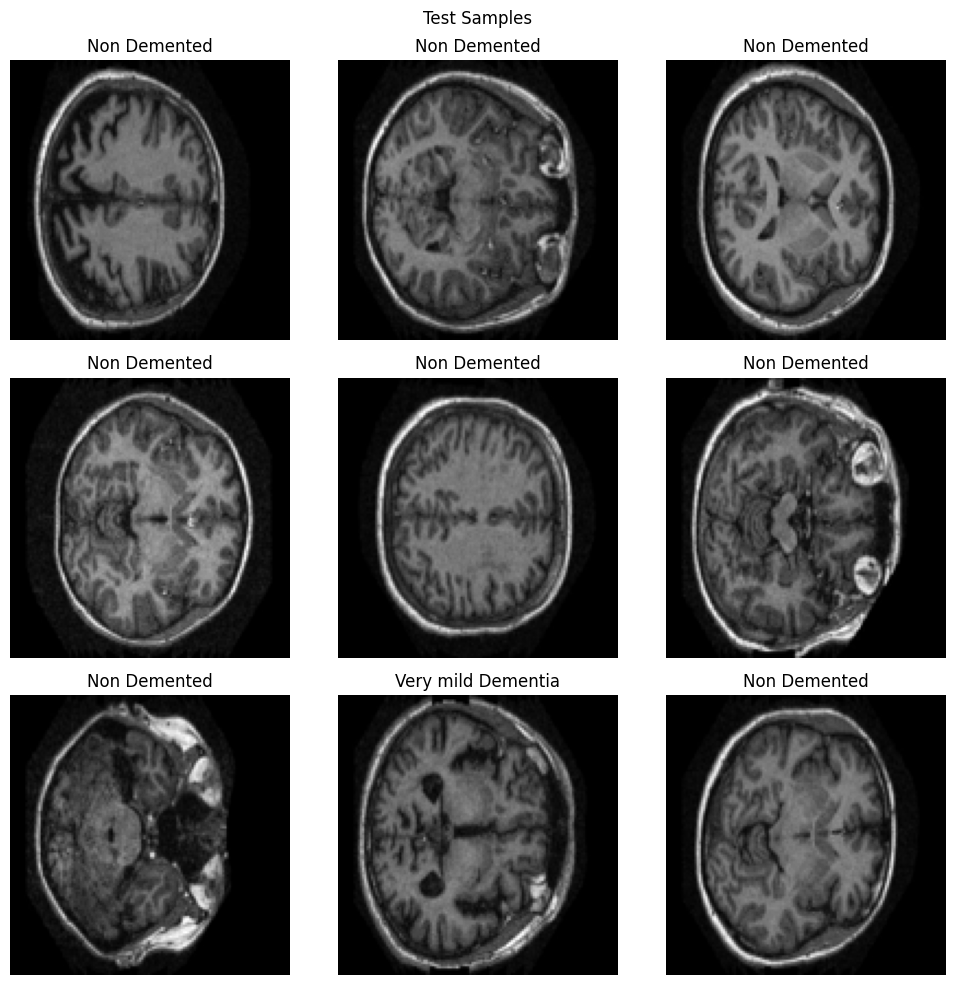

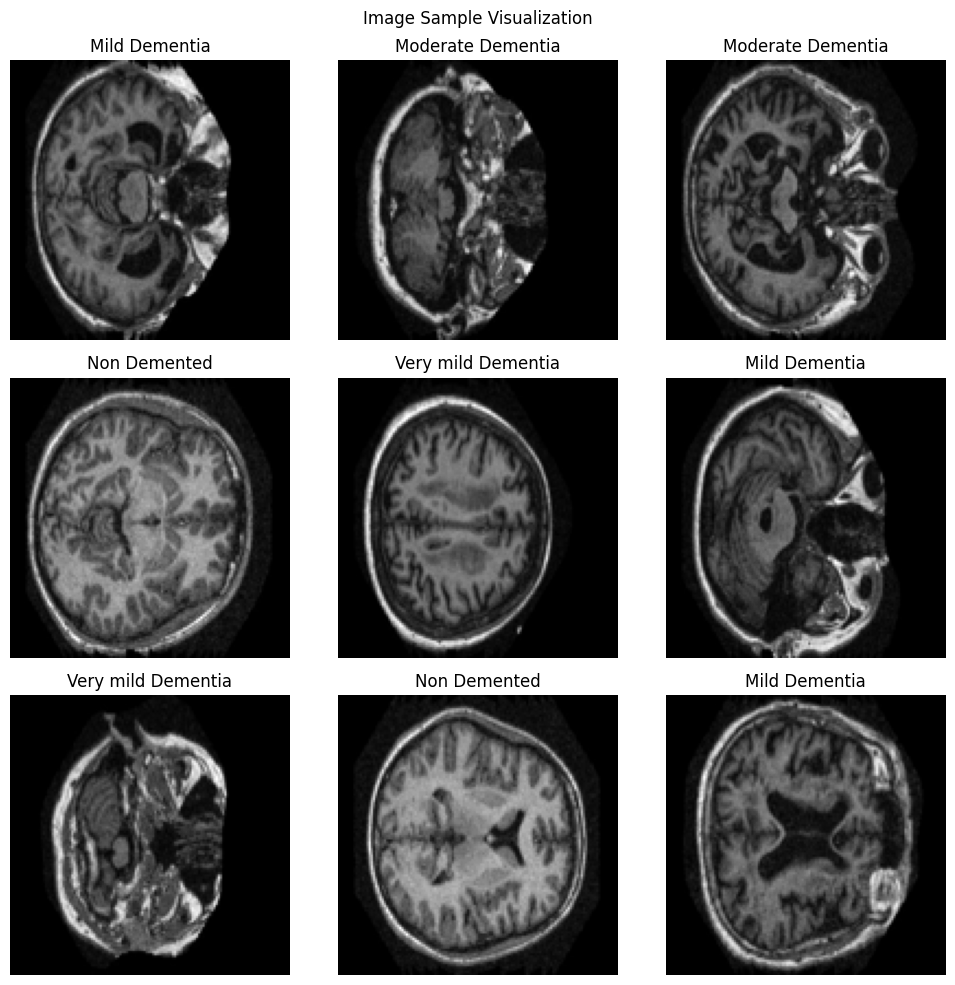

In [6]:
# visualize random samples from training, validation, and test
def visualize_samples(X, y, classes, num_samples=9, title="Dataset Samples"):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        idx = random.randint(0, len(X) - 1)
        img = X[idx].reshape(IMAGE_SIZE)  # Ensure image dimensions are correct
        plt.subplot(3, 3, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(classes[y[idx]])
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize_samples(X_train, y_train, classes, title="Training Samples")
visualize_samples(X_val, y_val, classes, title="Validation Samples")
visualize_samples(X_test, y_test, classes, title="Test Samples")


def svm_image_sample_visualization(X, y, classes, num_samples = 9):
   plt.figure(figsize = (10, 10))
   num_classes = len(classes)

   # calc num of samples per class
   samples_per_class = num_samples // num_classes
   remainder = num_samples % num_classes
   sampled_indices = []

   for i, class_name in enumerate(classes):
      class_idx = i
      class_indices = np.where(y == class_idx)[0]

      # handle cases where a class has fewer samples than desired
      n_samples = samples_per_class + (1 if i < remainder else 0)
      n_samples = min(n_samples, len(class_indices))

      if n_samples > 0:
         sampled = np.random.choice(class_indices, n_samples, replace = False)
         sampled_indices.extend(sampled)
      else:
         print(f"Not enough samples to display for class '{class_name}'.")
   
   random.shuffle(sampled_indices)

   for i, idx in enumerate(sampled_indices):
      plt.subplot(3, 3, i + 1)
      img = X[idx].reshape(IMAGE_SIZE)
      plt.imshow(img, cmap='gray')
      plt.axis("off")
      plt.title(classes[y[idx]])

   plt.suptitle("Image Sample Visualization")
   plt.tight_layout()
   plt.show()

svm_image_sample_visualization(X_train, y_train, classes, num_samples=9)

## Feature Scaling and Dimensionality Reduction

In [7]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC  
import os
import joblib
import numpy as np  

# Convert datasets to float32 to reduce memory usage
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

# undersampling strat
# Identify unique class labels and their counts
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(f"Original class distribution: {class_distribution}")

sampling_strategy = {
    2: 3000,  # Non Demented
    3: 3000   # Very Mild Dementia
}

# ensure 2/3 are majority classes
for cls in sampling_strategy.keys():
    if cls not in class_distribution:
        raise ValueError(f"Class label {cls} not found in y_train.")
    if class_distribution[cls] < sampling_strategy[cls]:
        raise ValueError(f"Cannot undersample class {cls} to {sampling_strategy[cls]} as it has only {class_distribution[cls]} samples.")

# pipeline w/ undersampling and linearSVC
# Initialize the pipeline with scaling, PCA, undersampling, and LinearSVC
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.80, random_state=42)),  
    ('under', RandomUnderSampler(
        sampling_strategy=sampling_strategy,
        random_state=42
    )),
    ('svm', LinearSVC(
        class_weight='balanced',  
        random_state=42,
        max_iter=10000,
        dual=False 
    ))
])

# Train the model 
print("Training LinearSVC model with PCA and undersampling: ...")
pipeline.fit(X_train, y_train)
print("Training completed.")


# Save the trained pipeline for future use
model_path = "../models/linear_svc_pipeline_pca_undersampled.joblib"  
os.makedirs(os.path.dirname(model_path), exist_ok=True)
joblib.dump(pipeline, model_path)
print(f"Trained LinearSVC pipeline with PCA and undersampling saved to {model_path}")


Original class distribution: {0: 3502, 1: 341, 2: 47055, 3: 9607}
Training LinearSVC model with PCA and undersampling: ...
Training completed.
Trained LinearSVC pipeline with PCA and undersampling saved to ../models/linear_svc_pipeline_pca_undersampled.joblib


## Evaluating SVM on Validation

Validation Metrics
Accuracy: 0.7606
Precision: 0.8455
Recall: 0.7606
F1 Score: 0.7831


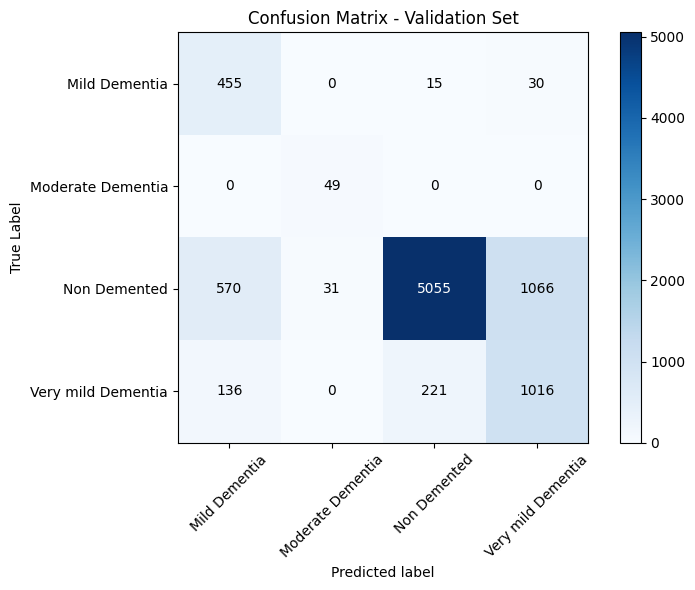

In [8]:
# predict on validation set
y_val_pred = pipeline.predict(X_val)

# calc evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Validation Metrics")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# annotate confusion matrix
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), 
                 ha="center", va="center",
                 color = "white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()



## ROC Curve and AUC for Validation Set

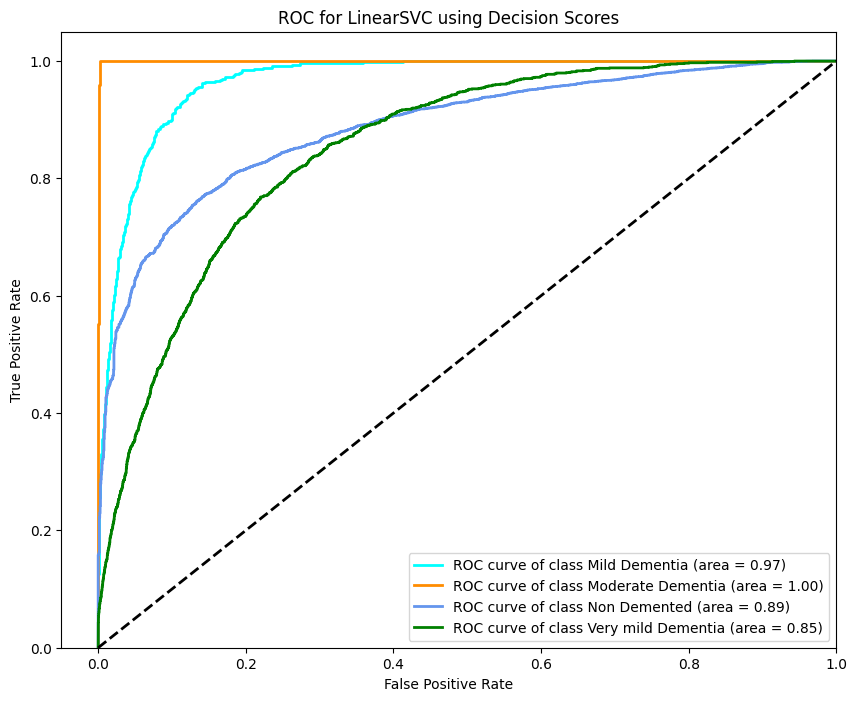

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# binarize output
y_val_binarized = label_binarize(y_val, classes=range(len(classes)))
n_classes = y_val_binarized.shape[1]

# get decision scores
y_val_scores = pipeline.decision_function(X_val)

# get roc curve/area per class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_val_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# visualization
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']  

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for LinearSVC using Decision Scores')
plt.legend(loc="lower right")
plt.show()


## SVM Model on Test

Test Metrics:
Accuracy: 0.7646
Precision: 0.8463
Recall: 0.7646
F1 Score: 0.7858


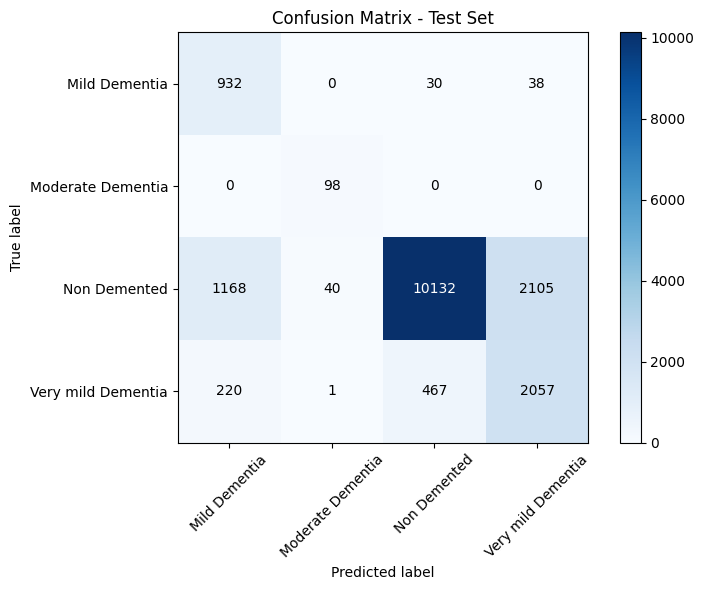

In [12]:
# evaluation on the test set
y_test_pred = pipeline.predict(X_test)

# evaluation metrics on test
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Test Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Confusion Matrix for Test Set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_test, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix_test.max() / 2.
for i in range(conf_matrix_test.shape[0]):
    for j in range(conf_matrix_test.shape[1]):
        plt.text(j, i, format(conf_matrix_test[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix_test[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()
